In [1]:
import pandas as pd
import numpy as np
import pickle
import os
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                        roc_curve, auc, roc_auc_score, log_loss)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [2]:
data_path = "/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/pipeline/data_extracted_features/three_class_pp_5s_0.5.csv"
features = pd.read_csv(data_path)
features.drop(columns=['center_time', 'start_time', 'end_time'], inplace=True)



In [3]:
X = features.drop(columns=['label', 'experiment_id'])
y = features['label']
groups = features['experiment_id']

splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train, groups_test = groups.iloc[train_idx], groups.iloc[test_idx]

In [4]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [5]:
select_feature = SelectKBest(f_classif, k=20).fit(X_train, y_train)
selected_features_df = pd.DataFrame({'Feature':list(X_train.columns),
                                    'Scores':select_feature.scores_})
selected_features_df.sort_values(by='Scores', ascending=False)

,Feature,Scores
81,gyr_y_hjorth_frequency,75.673145
78,gyr_y_spectral_spread,71.743960
11,acc_x_spectral_flatness,70.653630
98,gyr_z_hjorth_frequency,70.087865
95,gyr_z_spectral_spread,65.791367
...,...,...
15,acc_x_spectral_kurtosis,8.093034
28,acc_y_spectral_flatness,7.958113
33,acc_y_snr,5.893061
87,gyr_z_mean,3.946727


### XGBoost

In [6]:
model = RandomForestClassifier(
        n_estimators=255,
        max_depth=8,
        min_samples_split=15,
        min_samples_leaf=6,
        max_features='log2',
        bootstrap=True,
        class_weight='balanced',
        random_state=42)

In [7]:
X_train_selected = select_feature.transform(X_train)
X_test_selected = select_feature.transform(X_test)

In [8]:
model.fit(X_train_selected, y_train)

,n_estimators,255
,criterion,'gini'
,max_depth,8
,min_samples_split,15
,min_samples_leaf,6
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [9]:
classes = ['pre-void','void', 'post-void']
y_pred = model.predict(X_test_selected)
y_pred_prob = model.predict_proba(X_test_selected)


# Convert back to original labels for the report
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_original = label_encoder.inverse_transform(y_pred)


# Generate classification report with actual label names
report = classification_report(y_test_original, y_pred_original, labels=classes, target_names=classes)
print(report)

              precision    recall  f1-score   support

    pre-void       0.21      0.46      0.28        46
        void       0.75      0.48      0.58        94
   post-void       0.40      0.31      0.35       103

    accuracy                           0.40       243
   macro avg       0.45      0.42      0.41       243
weighted avg       0.50      0.40      0.43       243



Text(0.5, 1.0, 'Confusion Matrix: 5s_0.5_RandomForest')

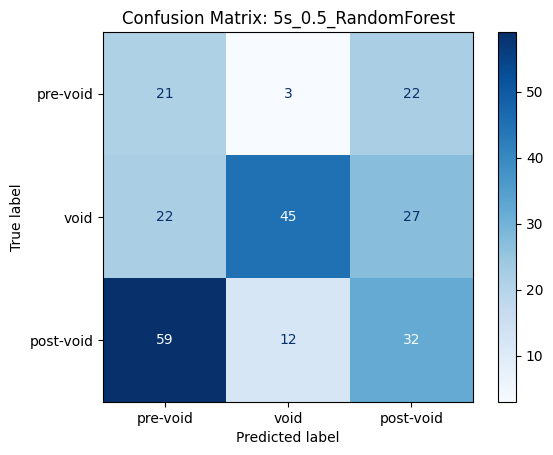

In [10]:
# Confusion matrix 
cm = confusion_matrix(y_test_original, y_pred_original, labels=classes)  # [void, non-void]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix: 5s_0.5_RandomForest')

# file_path = "/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/classifiers_to_hmm/plots/confusion_matrix/three_class_rf_5s_0.5.png"
# plt.savefig(file_path)
# plt.close()
# plt.show()

## Overlay predictions on original plots

In [21]:
with open('../data/df_dict_imu.pkl', 'rb') as f:
    imu_dict = pickle.load(f)
with open('../data/df_dict_urineestimate_method1.pkl', 'rb') as f:
    urine_estimates_dict = pickle.load(f)
with open('../data/df_minze_dict.pkl', 'rb') as f:
    ground_truth_dict = pickle.load(f)
    
gender = pd.read_excel('../data/demographics_uroflowmetry.xlsx', index_col=0)
gender.drop(['Age', 'Waist Circumference (cm)', 'Height (cm)', 'Weight (Kg)', 'GD Vol (ml)', 'NOTES'], axis=1, inplace=True)
sex = gender['Gender']
sex = np.array(sex)


In [22]:
features_df = pd.read_csv("/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/pipeline/data_extracted_features/three_class_pp_5s_0.5.csv")

In [23]:
voids = {
    'subj_1_void7': 5, 
    'subj_2_void2': 9,
    'subj_2_void7': 14,
    'subj_3_void8': 20,
    'subj_5_void2': 25,
    'subj_5_void3': 26,
    'subj_8_void1': 30,
    'subj_15_void1': 40,
    'subj_16_void1': 41
}

In [24]:
# Keep everything together for easier analysis
# ==========================================================================================
# Dataframe containing test set information
# groups: ids of data in the two and three class test set
# y_test: true labels of the test set of the two class data
# y_pred: predicted labels from the classifier
# three_class_actual: true labels of the test set of the three class data 
# ==========================================================================================

test_results = pd.DataFrame({
    'group': groups_test,
    'actual': y_test,
    'predicted': y_pred,
})

In [25]:
def plot_predictions_with_timing(features_df, predicted_labels, ax_pred):
    """
    Plot predictions using exact timing info from features DataFrame
    features_df and predicted_labels are already filtered for one instance
    """
    # Plot each prediction window
    void_label_added = False
    post_void_label_added = False
    pre_void_label_added = False
    
    for i, prediction in enumerate(predicted_labels):
        # Get timing info from features (convert seconds to ms to match your time axis)
        start_time = features_df.iloc[i]['start_time'] 
        # start_time = features_df.iloc[i]['center_time']
        end_time = features_df.iloc[i]['end_time'] 
        
        # Plot as colored spans
        if prediction == 2:  # Void prediction
            ax_pred.axvspan(start_time, end_time, alpha=0.7, color='lightgreen')
            void_label_added = True
        elif prediction == 0:  # Post void prediction
            ax_pred.axvspan(start_time, end_time, alpha=0.7, color='lightcoral')
            post_void_label_added = True
        elif prediction == 1:  # Pre void prediction
            ax_pred.axvspan(start_time, end_time, alpha=0.7, color='lightblue')
            pre_void_label_added = True

    
    # Set axis properties
    ax_pred.set_ylim(0, 1)
    ax_pred.set_ylabel('Predictions')
    ax_pred.set_yticks([0, 1])
    ax_pred.legend(loc='upper right')
    
    return ax_pred

In [29]:
for i_void_instance, void_instance in enumerate(voids.keys()):
    imu_data = imu_dict[void_instance]
    urine_estimates = urine_estimates_dict[void_instance]
    ground_truth = ground_truth_dict[void_instance]
    exp_id = voids[void_instance]
    
    # Urination event is the first and last time of the ground truth data
    urination_event = [ground_truth['Time'].iloc[0], ground_truth['Time'].iloc[-1]] 
    
    # Create a figure with 2 subplots (shared x-axis)
    fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # --- Top subplot: Accelerometer ---
    ax_top.plot(imu_data['time'], imu_data['acc_x'], color='0.2', label='acc_x')
    ax_top.plot(imu_data['time'], imu_data['acc_y'], color='0.5', label='acc_y')
    ax_top.plot(imu_data['time'], imu_data['acc_z'], color='0.7', label='acc_z')
    ax_top.set_ylabel('Acceleration (m/s²)')
    ax_top.set_title(f'IMU Data with Predictions for {void_instance} - {exp_id}', fontsize=14, fontweight='bold')
    ax_top.legend(loc='best')
    ax_top.grid(True)
    
    # Add vertical lines for urination event
    ax_top.axvline(x=urination_event[0], color='red', linestyle='--', alpha=0.7)
    ax_top.axvline(x=urination_event[1], color='red', linestyle='--', alpha=0.7)
    
    # Add phase labels at the top of the top subplot only
    x_min, x_max = ax_top.get_xlim()
    y_min, y_max = ax_top.get_ylim()
    
    # Pre-void label
    pre_void_center = (x_min + urination_event[0]) / 2
    ax_top.text(pre_void_center, y_max * 0.95, 'Pre-void', ha='center', va='top', 
                fontsize=12, fontweight='bold', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))
    
    # Void label
    void_center = (urination_event[0] + urination_event[1]) / 2
    ax_top.text(void_center, y_max * 0.95, 'Void', ha='center', va='top', 
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))
    
    # Post-void label
    post_void_center = (urination_event[1] + x_max) / 2
    ax_top.text(post_void_center, y_max * 0.95, 'Post-void', ha='center', va='top', 
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7))
    
    # --- Bottom subplot: Gyroscope ---
    ax_bottom.plot(imu_data['time'], imu_data['gyr_x'], color='0.2', label='gyr_x', alpha=0.8)
    ax_bottom.plot(imu_data['time'], imu_data['gyr_y'], color='0.5', label='gyr_y', alpha=0.8)
    ax_bottom.plot(imu_data['time'], imu_data['gyr_z'], color='0.7', label='gyr_z', alpha=0.8)
    ax_bottom.set_ylabel('Angular Velocity (rad/s)')
    ax_bottom.set_xlabel('Time (ms)')
    ax_bottom.legend(loc='best')
    ax_bottom.grid(True)
    
    # --- Overlay predictions on bottom subplot ---
    ax_pred = ax_bottom.twinx()
    predicted_labels = test_results[test_results['group'] == exp_id]['predicted'].tolist()
    actual_labels = test_results[test_results['group'] == exp_id]['actual'].tolist()
    features_df_ = features_df[features_df['experiment_id'] == exp_id]
    print(f"Experiment ID: {exp_id}; Instance: {void_instance}")
    print(predicted_labels)
    plot_predictions_with_timing(features_df_, predicted_labels, ax_pred)
    
    # Add vertical lines for urination event
    ax_bottom.axvline(x=urination_event[0], color='red', linestyle='--', alpha=0.7)
    ax_bottom.axvline(x=urination_event[1], color='red', linestyle='--', alpha=0.7)
        
    path = "/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/classifiers_to_hmm/plots/rf_5s_0.5/direct_three"
    # Save plot   
    if not os.path.exists(path):
        os.mkdir(path)
        filename = os.path.join(path, f'three_class_{void_instance}({voids[void_instance]})_overlay.png')
        plt.savefig(filename)
    else:
        filename = os.path.join(path, f'three_class_{void_instance}({voids[void_instance]})_overlay.png')
        plt.savefig(filename)
    plt.close()

Experiment ID: 5; Instance: subj_1_void7
[1, 1, 1, 0, 1, 2, 2, 2, 1, 2, 0, 1, 1]


/tmp/ipykernel_1077191/317987188.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_pred.legend(loc='upper right')


Experiment ID: 9; Instance: subj_2_void2
[1, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0]
Experiment ID: 14; Instance: subj_2_void7
[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 1, 1, 1, 0, 1, 2]
Experiment ID: 20; Instance: subj_3_void8
[0, 0, 1, 0, 2, 1, 1, 1, 0, 1, 2, 0]
Experiment ID: 25; Instance: subj_5_void2
[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 2, 2, 1, 0, 0, 1, 2, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0]
Experiment ID: 26; Instance: subj_5_void3
[1, 1, 0, 1, 1, 1, 0, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
Experiment ID: 30; Instance: subj_8_void1
[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2]
Experiment ID: 40; Instance: subj_15_void1
[1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 0, 1, 0, 1, 2, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1]
Experiment ID: 41; Instance: subj_16_void1
[0, 1, 1, 2